In [1]:
import gc
import os
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from itertools import product
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

In [2]:
np.random.seed(35)
rn.seed(35)
tf.random.set_seed(35)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4338503243329020024
xla_global_id: -1
]


In [3]:
file_path = "../../data/BG Ex data/"
model_path = "../../model/"
file_list = os.listdir(file_path)
fold_info = np.load("../../data/BG_Fold_Info.npz", allow_pickle=True)

In [4]:
pred_list=[]

for FOLD in range(10):
    soft = f'../../data/BG Avg/Test_Fold{FOLD}_avg.csv'
    lr_lasso = f'../../data/BG LBStack/Test_Fold{FOLD}_lbstack.csv'
    naive = f'../../data/BG Naive/Test_Fold{FOLD}.csv'
    
    soft_df = pd.read_csv(soft)
    lr_lasso_df = pd.read_csv(lr_lasso)
    naive = pd.read_csv(naive)
    
    pred_df = naive[["file_name"]]
    pred_df["Linear"] = lr_lasso_df["LR"]
    pred_df["Lasso"] = lr_lasso_df["LASSO"]
    pred_df["Soft"] = soft_df["AVG"]
    pred_df["Real"] = naive["y12"]
    
    pred_list.append(pred_df)

In [5]:
pred_result = pd.concat(pred_list)
pred_result

,file_name,Linear,Lasso,Soft,Real
0,S084,201.924872,202.098126,203.662407,192
1,S084,195.801167,195.358026,197.385034,199
2,S084,195.550674,196.511771,195.809254,187
3,S084,188.399587,190.900504,192.697643,183
4,S084,201.867762,204.758007,204.411715,180
...,...,...,...,...,...
15903,S077,177.886735,178.188136,175.289791,158
15904,S077,172.379883,170.344046,172.945125,156
15905,S077,155.974675,154.046672,161.684766,154
15906,S077,159.621236,158.728785,167.334471,149


In [6]:
file_names = pred_result["file_name"].unique()

In [9]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def cal_rmse(df):
    file_name = df.file_name.unique()
    
    linear_rmse = root_mean_squared_error(df["Real"], df["Linear"])
    lasso_rmse = root_mean_squared_error(df["Real"], df["Lasso"])
    soft_rmse = root_mean_squared_error(df["Real"], df["Soft"])
    naive_rmse = root_mean_squared_error(df["Real"], df["Real"].shift(6))
    
    row = pd.DataFrame({
        'file_name': file_name,
        'Linear': linear_rmse,
        'Lasso': lasso_rmse,
        'Soft': soft_rmse,
        'Naive': naive_rmse
    })
    
    return(row)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def cal_mae(df):
    file_name = df.file_name.unique()
    
    linear_mae = mean_absolute_error(df["Real"], df["Linear"])
    lasso_mae = mean_absolute_error(df["Real"], df["Lasso"])
    soft_mae = mean_absolute_error(df["Real"], df["Soft"])
    naive_mae = mean_absolute_error(df["Real"], df["Real"].shift(6))
    
    row = pd.DataFrame({
        'file_name': file_name,
        'Linear': linear_mae,
        'Lasso': lasso_mae,
        'Soft': soft_mae,
        'Naive': naive_mae
    })
    
    return(row)

In [10]:
rmse_result_list = []
for file in file_names:
    df = pred_result[pred_result["file_name"]==file]
    rmse_result_list.append(cal_rmse(df))
    
mae_result_list = []
for file in file_names:
    df = pred_result[pred_result["file_name"]==file]
    mae_result_list.append(cal_mae(df))

In [11]:
rmse_result = pd.concat(rmse_result_list)
rmse_result = rmse_result.reset_index().drop(["index"], axis=1)

mae_result = pd.concat(mae_result_list)
mae_result = mae_result.reset_index().drop(["index"], axis=1)

In [12]:
rmse_result

,file_name,Linear,Lasso,Soft,Naive
0,S084,18.463804,18.546061,16.963306,19.634115
1,S036,19.989242,19.682783,19.158717,24.728393
2,S107,22.463459,22.293585,21.839688,22.013822
3,S075,27.075735,26.899861,27.079659,31.030437
4,S082,22.625913,22.650717,22.996101,23.800137
...,...,...,...,...,...
125,S042,19.841612,19.744514,20.116724,24.257071
126,S034,26.031340,25.656936,24.238909,28.514391
127,S062,20.352664,19.999085,19.933739,22.219832
128,S005,20.550365,20.462300,19.927242,23.114865


In [13]:
mae_result

,file_name,Linear,Lasso,Soft,Naive
0,S084,12.212939,12.246950,11.846796,13.626911
1,S036,13.679358,13.534375,13.735504,18.014366
2,S107,15.804578,15.691618,15.187566,15.170929
3,S075,19.380116,19.263230,19.399652,22.367851
4,S082,17.666800,17.503505,17.386555,17.415094
...,...,...,...,...,...
125,S042,14.342152,14.329465,15.563196,18.790826
126,S034,20.262013,19.807347,18.967354,22.265306
127,S062,14.810677,14.477851,14.227845,15.897674
128,S005,15.871370,15.759822,15.268841,17.913425


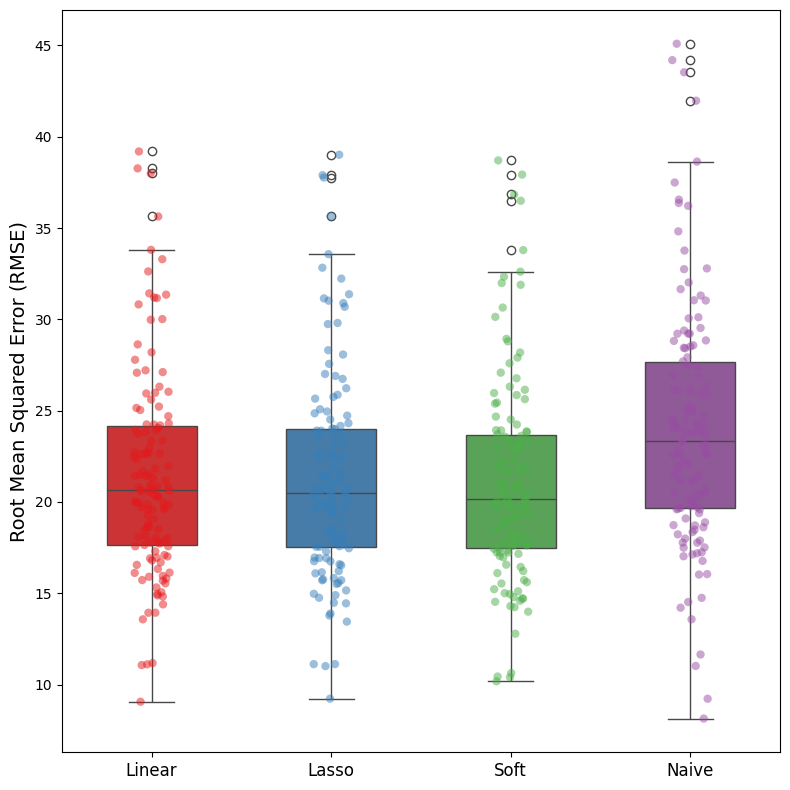

In [21]:
# Boxplot과 Jitterplot을 그릴 열을 선택합니다.
columns_to_plot = ['Linear', 'Lasso', 'Soft', 'Naive']

# Boxplot과 Jitterplot을 함께 그립니다.
plt.figure(figsize=(8, 8))

# Boxplot을 그립니다.
sns.boxplot(data=rmse_result[columns_to_plot], width=0.5, palette="Set1")

# Jitterplot을 Boxplot 왼쪽에 그리고 색상을 동일하게 지정합니다.
sns.stripplot(data=rmse_result[columns_to_plot], jitter=True, palette="Set1", alpha=0.5, size=6)

# 그래프에 제목과 라벨을 추가합니다.
plt.xticks(fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)

# 그래프를 표시합니다.
plt.tight_layout()
plt.grid(False)
plt.savefig('../../Fig7.png')
plt.show()

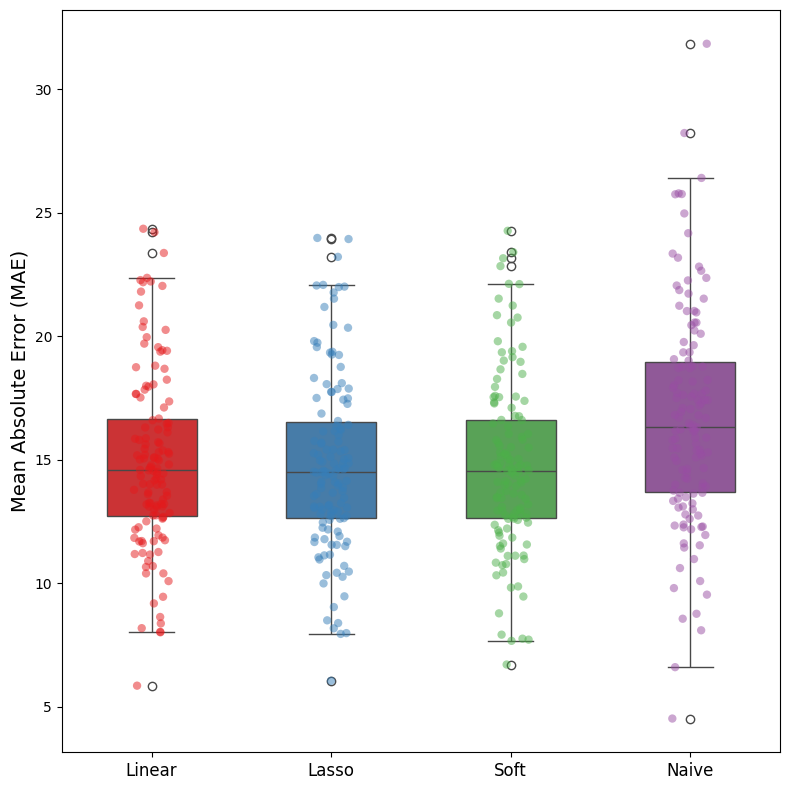

In [22]:
# Boxplot과 Jitterplot을 그릴 열을 선택합니다.
columns_to_plot = ['Linear', 'Lasso', 'Soft', 'Naive']

# Boxplot과 Jitterplot을 함께 그립니다.
plt.figure(figsize=(8, 8))

# Boxplot을 그립니다.
sns.boxplot(data=mae_result[columns_to_plot], width=0.5, palette="Set1")

# Jitterplot을 Boxplot 왼쪽에 그리고 색상을 동일하게 지정합니다.
sns.stripplot(data=mae_result[columns_to_plot], jitter=True, palette="Set1", alpha=0.5, size=6)

# 그래프에 제목과 라벨을 추가합니다.
plt.xticks(fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)

# 그래프를 표시합니다.
plt.tight_layout()
plt.grid(False)
plt.savefig('../../Fig8.png')
plt.show()